## See [Tests](#Tests)

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle

from scipy.constants import mu_0
import desc.io

from desc.basis import PowerSeries
from desc.compute import compute_rotational_transform
from desc.compute.utils import *
from desc.equilibrium import Equilibrium
from desc.grid import *
import desc.io
from desc.plotting import plot_comparison, plot_grid, plot_surfaces
from desc.profiles import PowerSeriesProfile, SplineProfile
from desc.transform import Transform

DESC version 0.5.1+205.g755cb41.dirty, using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 7.37 GB available memory


## Visualizing grids

In [3]:
# def print_grid(grid, stop=None, quantity=None):
#     """
#     Parameters
#     ----------
#     grid
#         Prints nodes and spacing.
#     stop : int
#         Max number of nodes to print. Defaults to entire grid.
#     quantity : ndarray
#         A quantity to print alongside the grid. i.e. data["iota"]
#     """
#     assert (
#         grid.num_nodes // grid.num_zeta
#         == np.where(~np.isclose(grid.nodes[:, 2], 0))[0][0]
#     )
#     print(grid.L, grid.M, grid.N, grid.NFP, grid.sym, grid.node_pattern)
#     print(grid.num_rho, grid.num_theta, grid.num_zeta)
#     print("nodes", "             ", "spacing")
#     if stop is None:
#         stop = grid.num_nodes
#     if quantity is None:
#         for i, e in enumerate(zip(grid.nodes, grid.spacing)):
#             a, b = e
#             print(a, b)
#             if i > stop:
#                 break
#     else:
#         for i, e in enumerate(zip(grid.nodes, grid.spacing, quantity)):
#             a, b, c = e
#             print(a, b, c)
#             if i > stop:
#                 break


def get_grid(eq, use_quad_grid=True):
    """
    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.
    use_quad_grid : bool
        Whether to use a quadrature grid.

    Returns
    -------
    ConcentricGrid or QuadratureGrid
        Grid with resolution used by the given equilibrium.
    """
    if use_quad_grid:
        return QuadratureGrid(
            L=eq.L_grid,
            M=eq.M_grid,
            N=eq.N_grid,
            NFP=eq.NFP,
        )
    else:
        return ConcentricGrid(
            L=eq.L_grid,
            M=eq.M_grid,
            N=eq.N_grid,
            NFP=eq.NFP,
            sym=eq.sym,
        )

## Grabbing VMEC/DESC outputs

In [4]:
# def get_vmec_data(name, quantity):
#     """
#     Parameters
#     ----------
#     name : str
#         Name of the equilibrium.
#     quantity: str
#         Name of the quantity to return.
#
#     Returns
#     -------
#     :rtype: (ndarray, ndarray)
#     rho : ndarray
#         Radial coordinate.
#     quantity : ndarray
#         Variable from VMEC output solved in fix current mode.
#     """
#     f = Dataset("examples/edu-vmec-current/wout_" + name + ".nc")
#     rho = np.sqrt(f.variables["phi"] / np.array(f.variables["phi"])[-1])
#     quantity = np.asarray(f.variables[quantity])
#     f.close()
#     return rho, quantity


def get_desc_eq(name, fix_current=False):
    """
    Parameters
    ----------
    name : str
        Name of the equilibrium.
    fix_current : bool
        True to use an equilibrium solved in fix current mode.
        False to use one solved in fix iota mode.

    Returns
    -------
    Equilibrium
        DESC equilibrium.
    """
    if fix_current:
        file = "../examples/DESC/current/" + name + "_output.h5"
    else:
        file = "../examples/DESC/" + name + "_output.h5"
    return desc.io.load(file)[-1]

## Plot functions

In [5]:
def plot_overlay(x, y1, label_1="", titles="", symlog=True, y2=None, label_2=None):
    """
    Parameters
    ----------
    x : ndarray
        x data
    y1, y2 : ndarray or tuple[ndarray]
        y data. will make multiple plots if y.ndim > 1
    label_1, label_2 : str
        y1, y2 plot labels
    titles : str or tuple[str]
        plot titles
    symlog : bool
        True to use a symmetric log scale; False to use linear scale.
    """
    # makes iteration easier
    if not isinstance(titles, tuple):
        titles = (titles,)
    y1 = np.atleast_2d(y1)
    if y2 is not None:
        y2 = np.atleast_2d(y2)
        assert y1.size == y2.size

    fig, ax = plt.subplots(ncols=y1.shape[0], figsize=(y1.shape[0] * 8, 5))
    ax = np.atleast_1d(ax)

    for i in range(y1.shape[0]):
        ax[i].plot(x, y1[i, :], label=label_1)
        ax[i].scatter(x, y1[i, :], s=9)
        if y2 is not None:
            ax[i].plot(x, y2[i, :], label=label_2)
            ax[i].scatter(x, y2[i, :], s=3)
        ax[i].set(
            yscale="symlog" if symlog else "linear",
            xlabel=r"$\rho$",
            title=titles[i],
            facecolor="white",
        )
        ax[i].grid()
        ax[i].legend(fontsize="x-small")

## Fitting output current to power series
This is used to set the fixed current profile coefficients on the fixed-current input files.
Because we know `compute_rotational_transform()` works properly, solving an equilibrium with the profiles below should produce similar equilibrium to the original fixed-iota equilibria.

# Tests
* Bootstrap method
    - This gives the same result for iota and iota_r and confirms that the `compute_rotational_transform()` function is correct.
    - The first point near the origin is weird, but this issue vanishes on Quadrature grids.
* compare fix iota to fix current solves
    - Works on DShape and Solovev. The rotational transform from the fixed-iota equilibrium is replicated.
    - Other inputs don't have nested surfaces. This shows that, while the `compute_rotational_transform()` function is correct, DESC may not converge back to the fixed-iota equilibrium. I'll need help fixing this, if it even is fixable.
* we could compare to VMEC, but VMEC actually does terribly on fixed-current equilibrium solves. Have to do guesswork on VMEC trying to get it to converge, which adds more unknown variables to testing. Probably better to use above two testing methods, then fiddle around with VMEC.

In [6]:
def compute_iota_bootstrap(eq, grid, current=None):
    """
    Compute iota using the current from data["I"] of an equilibrium solved in fix-iota mode as the current constraint.
    I called this the bootstrap method.

    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.
    grid : Grid
        Grid to compute over.
    current : PowerSeriesProfile
        Toroidal current profile.
        If not provided, the exact numerical values for current scraped directly from data["I"] on a fixed iota solve
        are used as the toroidal current constraint.
        The derivatives are computed by averaging data["B_theta_r"] and data["B_theta_rr"].

    Returns
    -------
    data : dict
        Dictionary of ndarray, shape(num_nodes,) of rotational transform profile.
        Keys are of the form 'X_y' meaning the derivative of X wrt y.
    """
    R_transform = Transform(
        grid, eq.R_basis, derivs=data_index["iota_r"]["R_derivs"], build=True
    )
    Z_transform = Transform(
        grid, eq.Z_basis, derivs=data_index["iota_r"]["R_derivs"], build=True
    )
    L_transform = Transform(
        grid, eq.L_basis, derivs=data_index["iota_r"]["L_derivs"], build=True
    )
    if current is not None:
        return compute_rotational_transform(
            eq.R_lmn,
            eq.Z_lmn,
            eq.L_lmn,
            i_l=None,
            c_l=current.params,
            Psi=eq.Psi,
            R_transform=R_transform,
            Z_transform=Z_transform,
            L_transform=L_transform,
            iota=None,
            current=current,
        )
    else:
        I = eq.compute("I", grid=grid)["I"]
        I_r = eq.compute("I_r", grid=grid)["I_r"]
        # storing current array for hardcode solve test method
        with open("heliotron current tesla-meter.pkl", "wb") as file:
            pickle.dump(I, file)
        with open("heliotron current_r tesla-meter.pkl", "wb") as file:
            pickle.dump(I_r, file)
        return compute_rotational_transform(
            eq.R_lmn,
            eq.Z_lmn,
            eq.L_lmn,
            i_l=None,
            c_l=None,
            Psi=eq.Psi,
            R_transform=R_transform,
            Z_transform=Z_transform,
            L_transform=L_transform,
            iota=None,
            current=1,  # dummy value to enter correct if statement of compute_rotational_transform
            current_from_fixed_iota=I,
            current_r_from_fixed_iota=I_r,
        )

/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_inverse_rho_idx' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_inverse_theta_idx' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_inverse_zeta_idx' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_current' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_inverse_rho_idx' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_inverse_theta_idx' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf

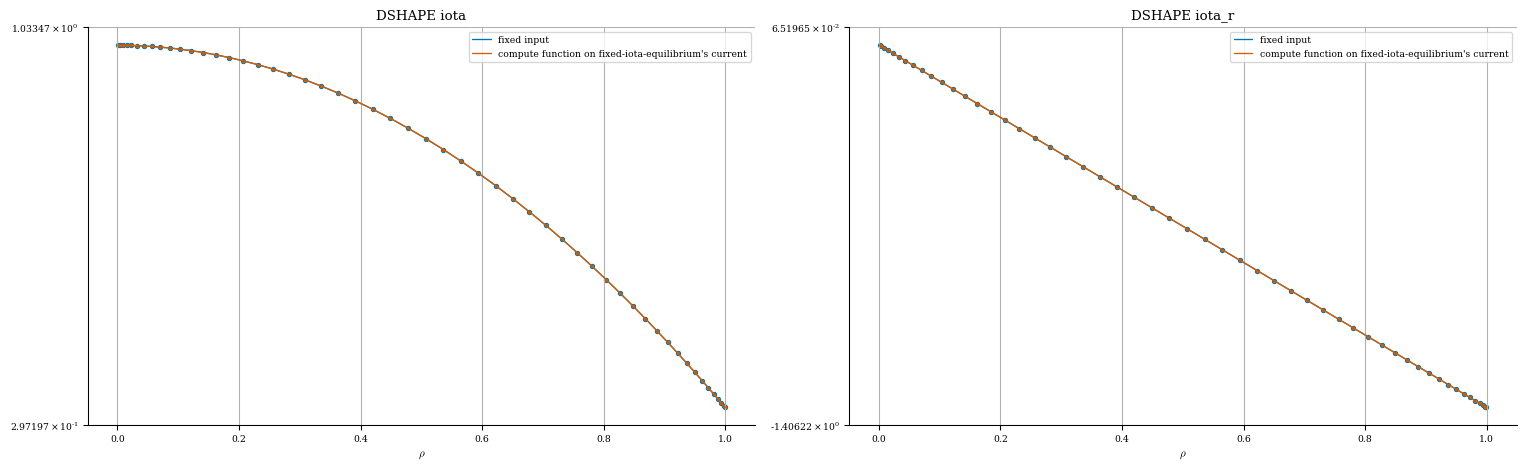

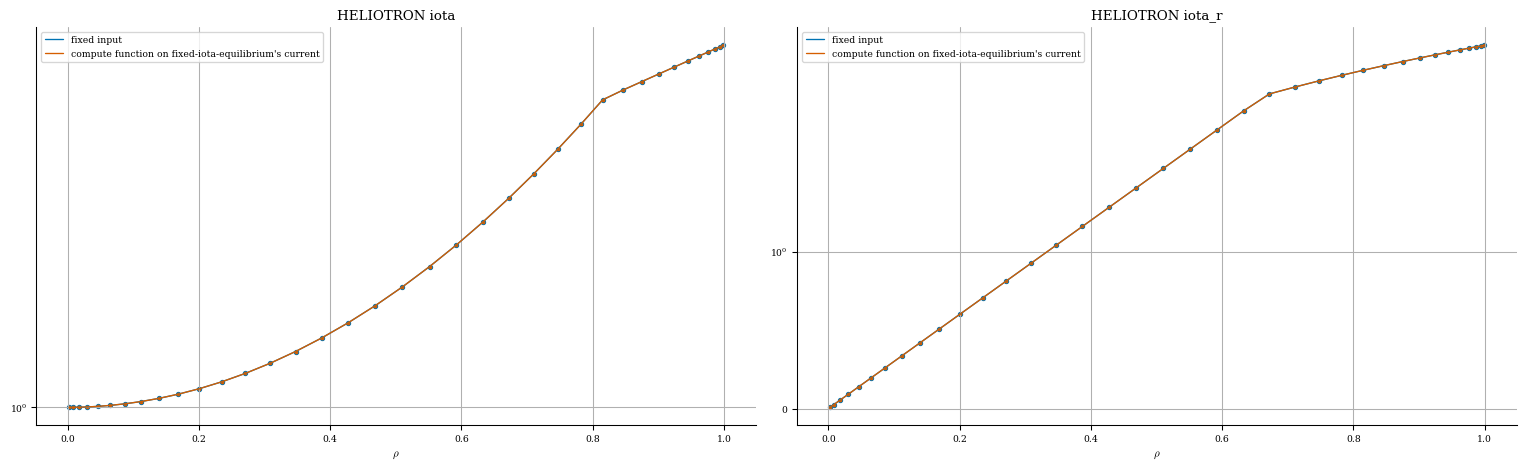

In [7]:
# feeding in the exact values of current from a fixed iota solve as the current input
# (not using a fit or a spline just pushing in data["I"] and surface_avg(B_theta_r) from fix iota solve)
def compare_iota_bootstrap(
    name: str, current: PowerSeriesProfile or SplineProfile = None
):
    eq = get_desc_eq(name)
    grid = get_grid(eq)
    data_1 = eq.compute("iota_r", grid=grid)
    data_2 = compute_iota_bootstrap(eq, grid, current)

    plot_overlay(
        x=compress(grid, grid.nodes[:, 0]),
        y1=(compress(grid, data_1["iota"]), compress(grid, data_1["iota_r"])),
        label_1="fixed input",
        y2=(compress(grid, data_2["iota"]), compress(grid, data_2["iota_r"])),
        label_2="compute function on fixed-iota-equilibrium's current",
        titles=tuple(name + " " + s for s in ("iota", "iota_r")),
    )


# these always match, but remember to uncomment the part in compute_rotational_transform() that reads the pickle file
compare_iota_bootstrap("DSHAPE")
compare_iota_bootstrap("HELIOTRON")

In [8]:
def get_current_fit(name, L=8, spline=False):
    """
    Fits a power series to the resulting current in amps of a fixed iota equilibrium.
    Plots an overlay of this fit.
    Prints the coefficients of this power series.

    Parameters
    ----------
    name : str
        Name of the equilibrium.
    L : int
        The highest order on power series fit.
    spline : bool
        True to fit to a spline instead.

    Returns
    -------
    PowerSeriesProfile or Spline
        Toroidal current profile in amps.
    """
    eq = get_desc_eq(name)
    rho = np.linspace(1 / 256, 1, 256)
    grid = LinearGrid(rho=rho, M=20, N=20)
    current_amps = 2 * np.pi / mu_0 * compress(grid, eq.compute("I", grid=grid)["I"])
    current_r_amps = (
        2 * np.pi / mu_0 * compress(grid, eq.compute("I_r", grid=grid)["I_r"])
    )

    if spline:
        # make sure the spline passes through 0 at axis for 0 current
        # and that it's first derivative at axis is also 0
        current_amps_for_spline = np.copy(current_amps)
        current_amps_for_spline[0] = 0
        spline = SplineProfile(
            values=np.insert(current_amps_for_spline, 0, 0), knots=np.insert(rho, 0, 0)
        )
        plot_overlay(
            x=rho,
            y1=(current_amps, current_r_amps),
            label_1="actual (amps)",
            y2=(
                compress(grid, spline.compute(grid=grid)),
                compress(grid, spline.compute(grid=grid, dr=1)),
            ),
            label_2="spline (amps)",
            titles=tuple(name + s for s in (" current", " current_r")),
        )
        return spline
    else:
        basis = PowerSeries(L=L, sym="even")
        derivs = np.vstack(([0, 0, 0], [1, 0, 0]))
        trans = Transform(LinearGrid(rho=rho), basis, derivs=derivs, build_pinv=True)
        coefficients = np.copy(trans.fit(current_amps))
        coefficients[0] = 0
        plot_overlay(
            x=rho,
            y1=(current_amps, current_r_amps),
            label_1="actual (amps)",
            y2=(trans.transform(coefficients), trans.transform(coefficients, dr=1)),
            label_2="fit (amps)",
            titles=tuple(name + s for s in (" current", " current_r")),
        )
        print(name)
        print(coefficients)
        return PowerSeriesProfile(params=coefficients, modes=basis.modes[:, 0])

/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_inverse_rho_idx' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_inverse_theta_idx' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_inverse_zeta_idx' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_current' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_inverse_rho_idx' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_inverse_theta_idx' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf

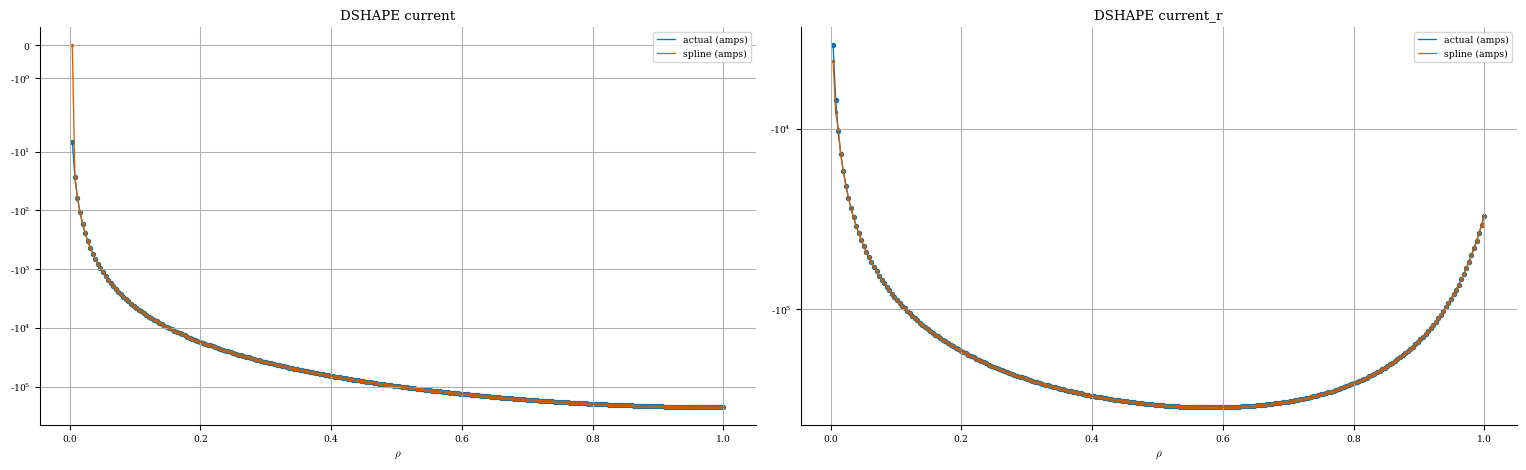

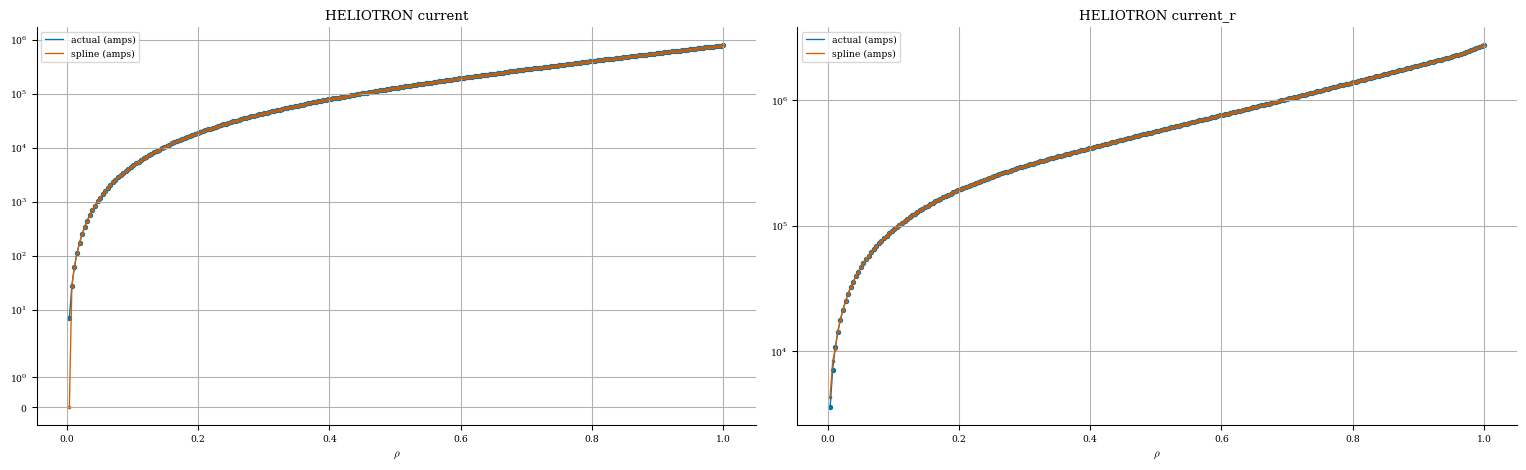

In [9]:
# see splines
dshape_spline = get_current_fit("DSHAPE", spline=True)
heliotron_spline = get_current_fit("HELIOTRON", spline=True)

/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_inverse_rho_idx' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_inverse_theta_idx' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_inverse_zeta_idx' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_current' was not loaded.
  warnings.warn(


DSHAPE
[      0.         -438588.61323804  175880.4841146    70143.3799594
  -32287.52095467]


/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_inverse_rho_idx' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_inverse_theta_idx' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_inverse_zeta_idx' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_current' was not loaded.
  warnings.warn(


HELIOTRON
[     0.         467277.16716524 128696.39363372 181782.55217781
   8548.45892309]


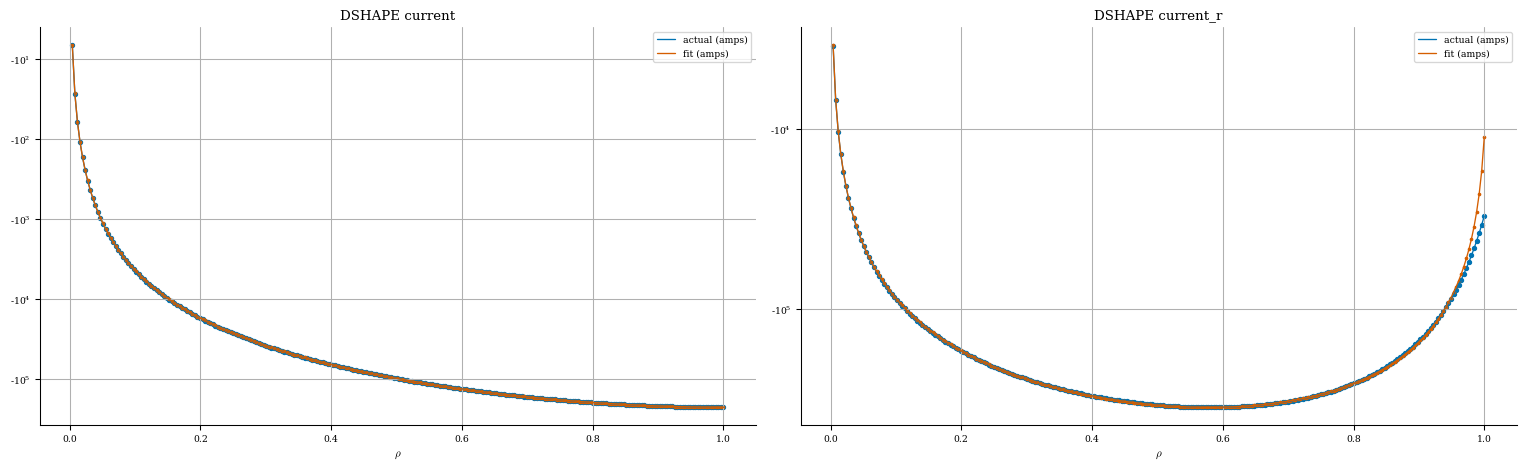

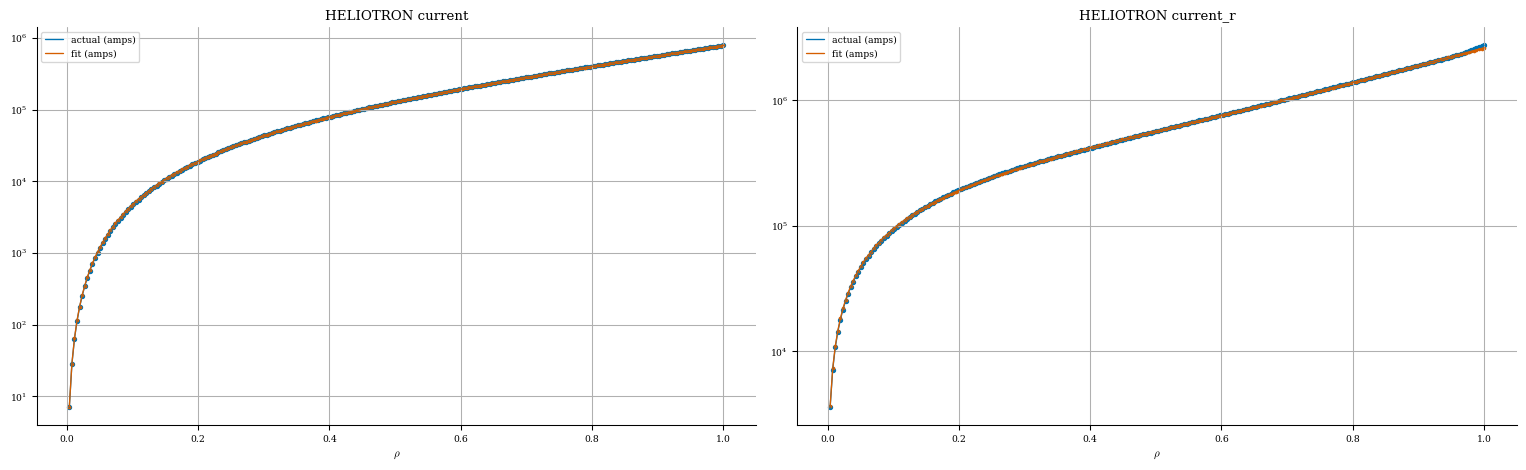

In [10]:
# same things as above but with power series
dshape_fit = get_current_fit("DSHAPE", spline=False)
heliotron_fit = get_current_fit("HELIOTRON", spline=False)

/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_inverse_rho_idx' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_inverse_theta_idx' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_inverse_zeta_idx' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_current' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_inverse_rho_idx' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_inverse_theta_idx' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf

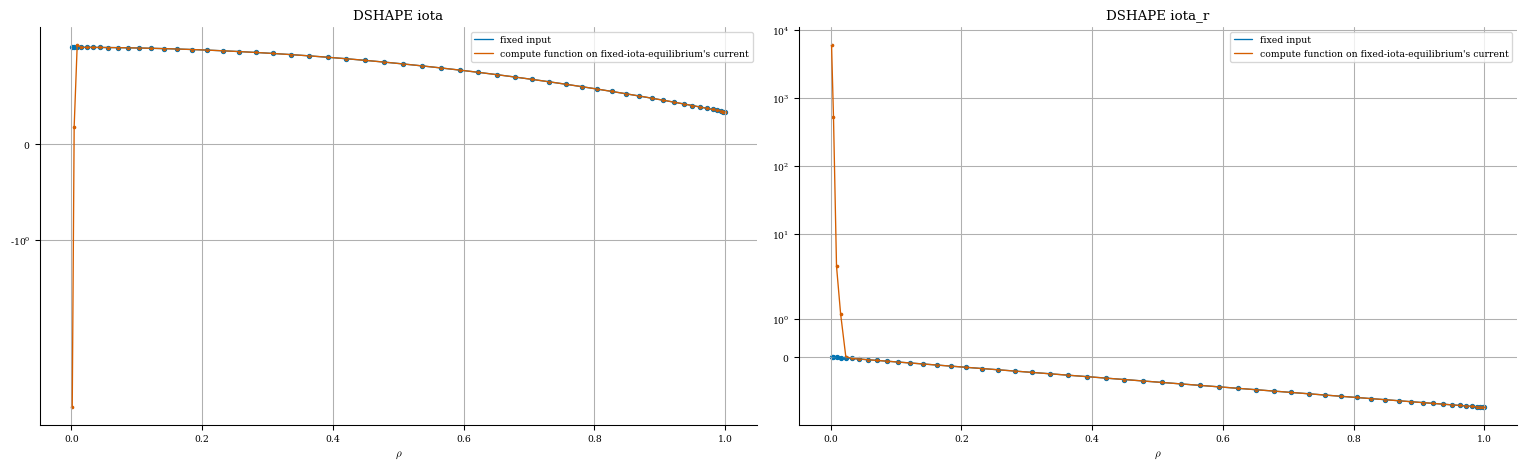

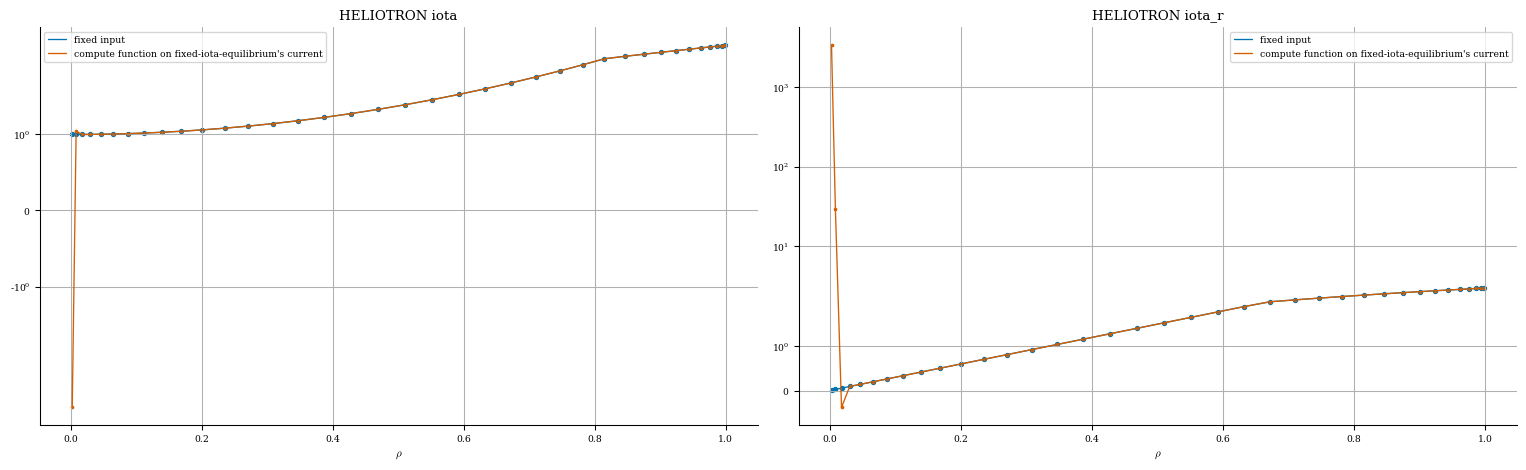

In [11]:
# compare the iota from a fix-iota equilibrium to the computed iota when a fit is given as current input
# (remember before we compared iota when the exact numerical values were given through data["I"])
# the jank near the origin is just because of our sketch way to enforce 0 derivative at origin on the spline
compare_iota_bootstrap("DSHAPE", dshape_spline)
compare_iota_bootstrap("HELIOTRON", heliotron_spline)

/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_inverse_rho_idx' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_inverse_theta_idx' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_inverse_zeta_idx' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_current' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_inverse_rho_idx' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_inverse_theta_idx' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/current/desc/io/hdf

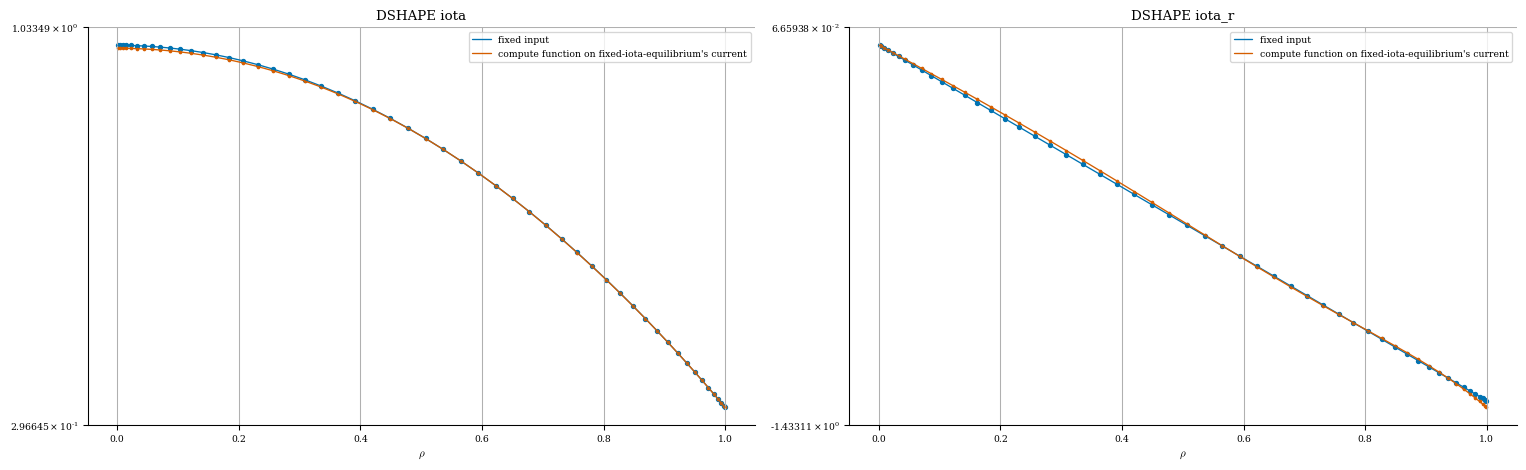

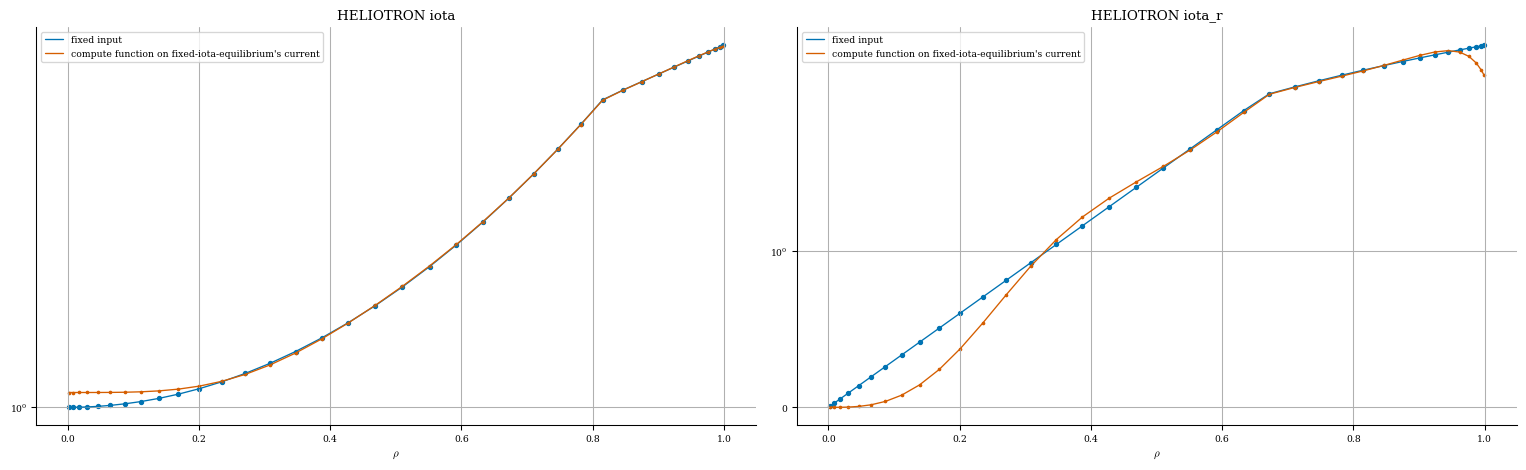

In [12]:
# same thing but with power series
compare_iota_bootstrap("DSHAPE", dshape_fit)
compare_iota_bootstrap("HELIOTRON", heliotron_fit)

## Compare iotas on equilibrium solved using fixed iota vs fixed current

In [13]:
# def compare_iota_fix_current_solve(name: str):
#     eq_1 = get_desc_eq(name)
#     eq_2 = get_desc_eq(name, fix_current=True)
#     plot_comparison([eq_1, eq_2])
#
#     grid = get_grid(eq_2)
#     data_1 = eq_1.compute("iota", grid=grid)
#     data_2 = eq_2.compute("iota", grid=grid)
#
#     plot_overlay(
#         x=compress(grid, grid.nodes[:, 0]),
#         y1=(compress(grid, data_1["iota"]), compress(grid, data_1["iota_r"])),
#         label_1="fixed iota solve",
#         y2=(compress(grid, data_2["iota"]), compress(grid, data_2["iota_r"])),
#         label_2="fixed current solve",
#         titles=tuple(name + " " + s for s in ("iota", "iota_r")),
#     )
#
# compare_iota_fix_current_solve("DSHAPE")
# compare_iota_fix_current_solve("HELIOTRON")
# # compare_iota_fix_current_solve("SOLOVEV")
# # compare_iota_fix_current_solve("ESTELL")
# # compare_iota_fix_current_solve("WISTELL-A")

In [14]:
# # eq_1 = get_desc_eq("HELIOTRON")
# eq_2 = get_desc_eq("HELIOTRON_quad", fix_current=True)
# plot_surfaces(eq_2)
# plot_comparison(get_desc_eq("HELIOTRON"), eq_2)